In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

Create training and test set with 500 examples of classes 5 and 8 respectively and change labels to 0 and 1. At the same time flip 30% of the labels.

In [5]:
train_set = [ex for ex in train_dataset if ex[1]==5][:500] + [ex for ex in train_dataset if ex[1]==8][:500]
test_set = [ex for ex in test_dataset if ex[1]==5][:500] + [ex for ex in test_dataset if ex[1]==8][:500]

In [6]:
train_set_01_images = []
test_set_01_images = []
train_set_01_labels = []
test_set_01_labels = []
num_flips = 500//3
for i,ex_tr in enumerate(train_set):
    ex_tr = list(ex_tr)
    if ex_tr[1]==5:
        if i<num_flips:
            ex_tr[1]=1
        else: 
            ex_tr[1]=0
    else: 
        if i<num_flips+500:
            ex_tr[1]=0
        else: 
            ex_tr[1]=1
    train_set_01_images.append(ex_tr[0])
    train_set_01_labels.append(ex_tr[1])
    
for ex_te in test_set:
    ex_te = list(ex_te)
    if ex_te[1]==5:
        ex_te[1]=0
    else: 
        ex_te[1]=1
    test_set_01_images.append(ex_te[0])
    test_set_01_labels.append(ex_te[1])    
    
train_set_01_images = torch.stack(train_set_01_images)
train_set_01_images = train_set_01_images.view(-1, 28*28)
test_set_01_images = torch.stack(test_set_01_images)
test_set_01_images = test_set_01_images.view(-1, 28*28)
train_set_01_labels = torch.tensor(train_set_01_labels)
test_set_01_labels = torch.tensor(test_set_01_labels)

n_sample = len(train_set_01_images)
np.random.seed(0)
order = np.random.permutation(n_sample)
train_set_01_images = train_set_01_images[order]
train_set_01_labels = train_set_01_labels[order]

In [7]:
print("size train set:", train_set_01_images.shape) 
print("size test set:", test_set_01_images.shape)

size train set: torch.Size([1000, 784])
size test set: torch.Size([1000, 784])


In [8]:
def train_logistic_regression(X_train, y_train, X_test, y_test, lr=0.01, num_steps=1000):
    model = nn.Linear(X_train.shape[1], 1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for step in range(num_steps):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs.squeeze(), y_test)
            test_losses.append(test_loss.item())

    return train_losses, test_losses

In [9]:
def train_random_feature_model(X_train, y_train, X_test, y_test, lr=0.01, num_steps=1000):
    F = torch.randn((2 * X_train.shape[1], X_train.shape[1]))
    X_train_rf = torch.relu(X_train.mm(F.t()))
    X_test_rf = torch.relu(X_test.mm(F.t()))

    model = nn.Linear(X_train_rf.shape[1], 1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for step in range(num_steps):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_rf)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_rf)
            test_loss = criterion(test_outputs.squeeze(), y_test)
            test_losses.append(test_loss.item())

    return train_losses, test_losses

In [10]:
X_train = train_set_01_images.float()
y_train = train_set_01_labels.float()
X_test = test_set_01_images.float()
y_test = test_set_01_labels.float()

In [11]:
X_train /= 255.0
X_test /= 255.0

train_losses_lr, test_losses_lr = train_logistic_regression(X_train, y_train, X_test, y_test)
train_losses_rf, test_losses_rf = train_random_feature_model(X_train, y_train, X_test, y_test)

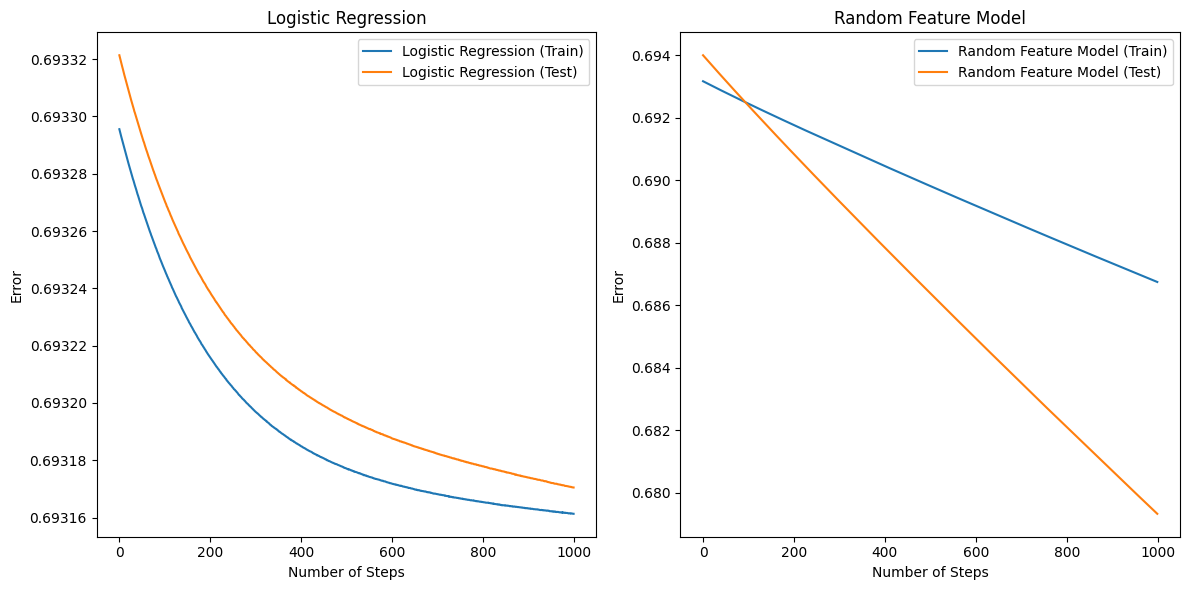

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses_lr, label='Logistic Regression (Train)')
plt.plot(test_losses_lr, label='Logistic Regression (Test)')
plt.title('Logistic Regression')
plt.xlabel('Number of Steps')
plt.ylabel('Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_rf, label='Random Feature Model (Train)')
plt.plot(test_losses_rf, label='Random Feature Model (Test)')
plt.title('Random Feature Model')
plt.xlabel('Number of Steps')
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
plt.show()